# Wrangle 
Data Acquisition + Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from wrangle import prep_fitbit, split_fitbit, visualize_split

In [2]:
# wrangled data 
df = prep_fitbit()

In [3]:
# drop categorical columns (only useful for visuals)
df.drop(columns=['month', 'weekday'], inplace=True)

In [4]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2.0,1347,93.0,0.0,0.0,566
2018-04-27,3649,9971,4.70,19.0,1158,219.0,46.0,17.0,1752
2018-04-28,3379,3521,1.66,2.0,702,155.0,22.0,11.0,1124
2018-04-29,2851,1639,0.77,0.0,891,122.0,0.0,0.0,602
2018-04-30,2825,1323,0.62,0.0,880,104.0,0.0,0.0,540


In [5]:
# split data into train 50% validate 30% test 20%
train, validate, test = split_fitbit(df)

---
# Modeling
> Forecasting: Predict the next two weeks of activity from 12/07/18 - 12/21/18

In [6]:
from model import evaluate, plot_and_eval, append_eval_df

In [7]:
# Create the empty dataframe for evaluation purposes
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

## Models

### Last Observed Value
The simplest method for forecasting is to predict all future values to be the last observed value.

#### Make Predictions



In [8]:
d = {}
for col in train.columns:
    if type(col) == 'int':
        d[col] = train[col][-1:][0]
        print(col)
    else:
        d[col] = round(train[col][-1:][0],2)
        print(col)

calories_burned
steps
distance
floors
minutes_sedentary
minutes_lightly_active
minutes_fairly_active
minutes_very_active
activity_calories


In [9]:
d

{'calories_burned': 4079,
 'steps': 12259,
 'distance': 5.78,
 'floors': 8.0,
 'minutes_sedentary': 704,
 'minutes_lightly_active': 213.0,
 'minutes_fairly_active': 23.0,
 'minutes_very_active': 56.0,
 'activity_calories': 2158}

In [10]:
#calories_burned = train['calories_burned'][-1:][0]
#steps = train['steps'][-1:][0]
#dollars = round(train['dollars_sold'][-1:][0],2)

yhat_df = pd.DataFrame(d, 
                       index = validate.index)

yhat_df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158
2018-08-17,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158


calories_burned -- RMSE: 921


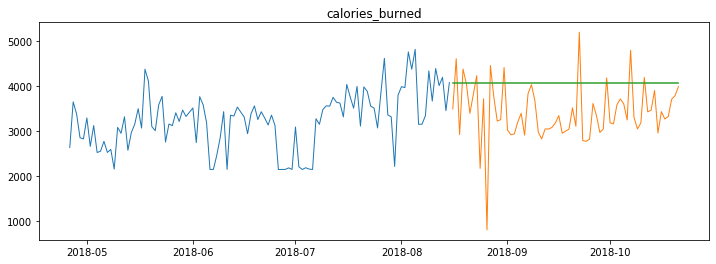

steps -- RMSE: 5156


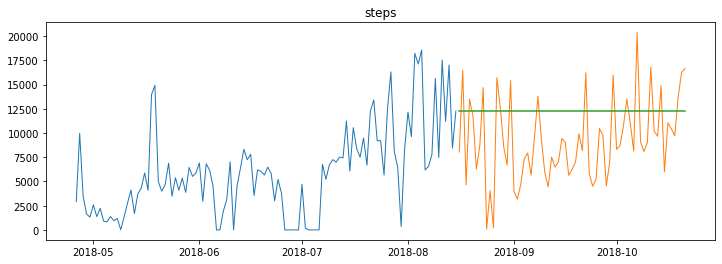

distance -- RMSE: 2


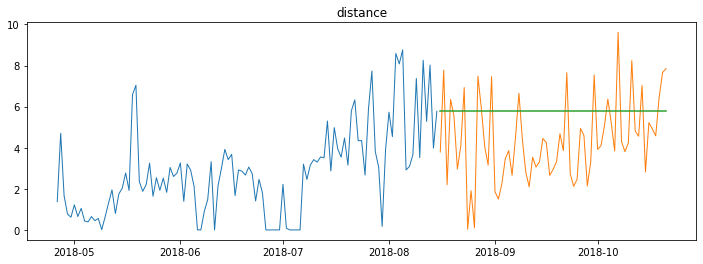

floors -- RMSE: 31


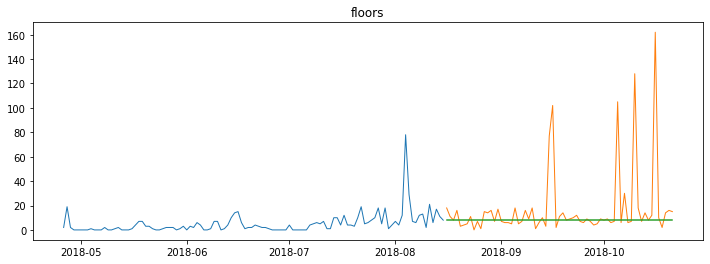

minutes_sedentary -- RMSE: 163


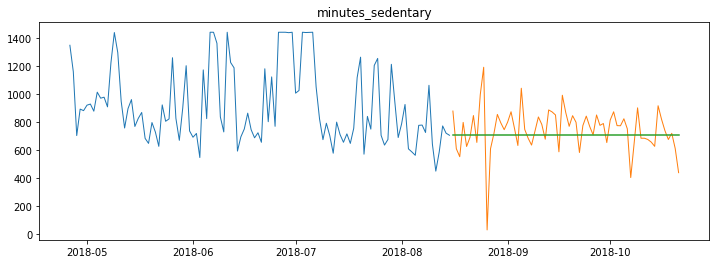

minutes_lightly_active -- RMSE: 64


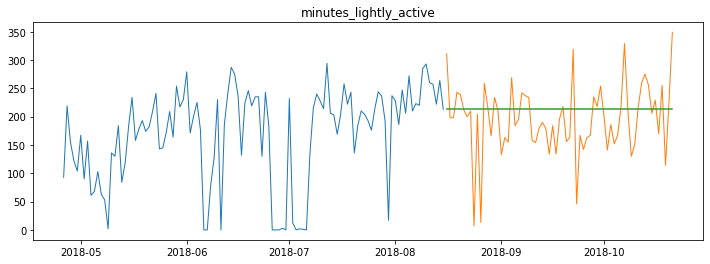

minutes_fairly_active -- RMSE: 18


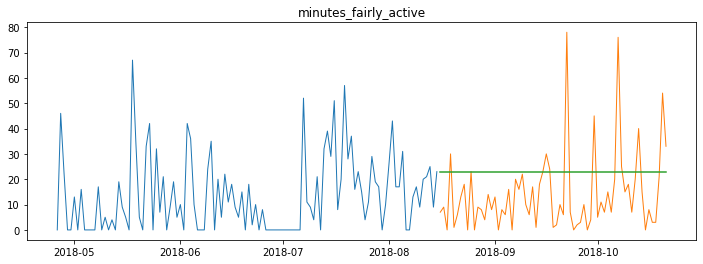

minutes_very_active -- RMSE: 38


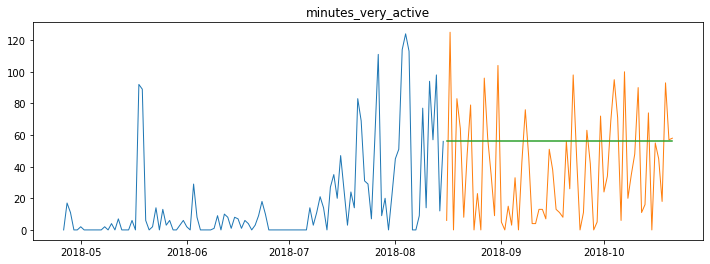

activity_calories -- RMSE: 897


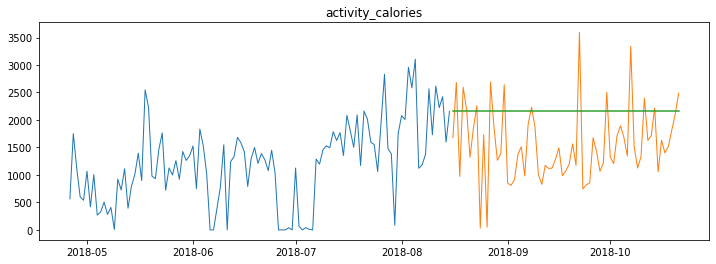

In [11]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

In [12]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'last_observed_value', 
                             target_var = col)

In [13]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
